In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Retrieve NIST SCD dataset from Citrine using matminer.
# The data will be stored in the df DataFrame.

first_retrieve = False #change it to indicate first time retrieve dataset or not

if first_retrieve:
    from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval

    api_key = "Your-API-Key" # insert your api key here
    c = CitrineDataRetrieval(api_key=api_key)
    df = c.get_dataframe(criteria={'data_set_id': '151803'})
    
    # Save downloaded dataset
    df.to_csv('NIST_CeramicDataSet.csv')
    df.to_pickle('NIST_CeramicDataSet.pkl')
else:
    df  = pd.read_pickle('NIST_CeramicDataSet.pkl')

In [9]:
# Save downloaded dataset
df.to_csv('NIST_CeramicDataSet.csv')
df.to_pickle('NIST_CeramicDataSet.pkl')

In [5]:
df  = pd.read_pickle('NIST_CeramicDataSet.pkl')

In [3]:
# Get the number of samples and number of features of the dataset
df.shape

(4098, 161)

In [4]:
# Looking at the first 5 entries
df.head()

,chemicalFormula,licenses,names,preparation,references,Axis Length,Axis Length-conditions,Axis Length-units,Bulk Modulus,Bulk Modulus-conditions,...,Thermal Expansion-conditions,Thermal Expansion-units,Thermal Shock Resistance,Thermal Shock Resistance-conditions,Thermal Shock Resistance-units,Weibull Modulus,Weibull Modulus-conditions,Weibull Strength,Weibull Strength-conditions,Weibull Strength-units
1,SiO2,[{'name': 'NIST_SRD-30'}],[Silica],NaN,"[{'citation': 'Gaseous Corrosion of Ceramics, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[Mullite composite],[{'name': 'Hot Pressing'}],[{'citation': 'Thermal Diffusivity/Conductivit...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Al2O3,[{'name': 'NIST_SRD-30'}],[Alumina],[{'name': 'Hot Pressing'}],"[{'citation': 'Mechanical Properties of Pure, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'name': 'Hot Pressing'}],[{'citation': 'Effect of Silicon Carbide Whisk...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'name': 'Hot Isostatic Pressing'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Taking a look at a sample entry
df.loc[35,:].dropna()

chemicalFormula                                                  WC.xCo
licenses                                      [{'name': 'NIST_SRD-30'}]
names                                                [Tungsten carbide]
references            [{'citation': 'Engineering Properties of Carbi...
Chemical Family                                                     W-C
Crystallinity                                           Polycrystalline
Density                                                            15.3
Density-conditions    [{'name': 'Temperature', 'scalars': [{'value':...
Density-units                                               g cm$^{-3}$
Name: 35, dtype: object

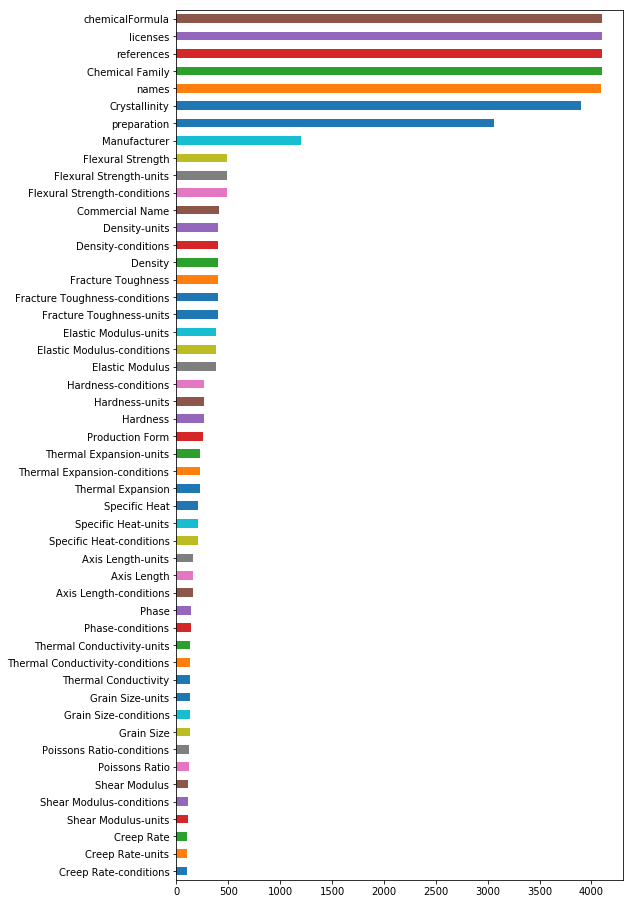

In [6]:
# Plot a bar chart showing the 50 most common features
plt.figure(figsize=(8,16))
df.count().sort_values()[-50:].plot.barh()
plt.show()

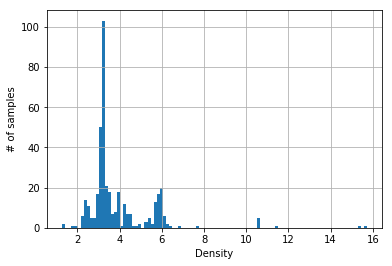

In [19]:
density = df['Density'].dropna()
density = pd.to_numeric(density, errors='coerce')
density.hist(bins=100)
plt.xlabel('Density')
plt.ylabel('# of samples')
plt.show()

# Featurization

In [195]:
feat = df.copy()
feat.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

In [205]:
# Parse the chemicalFormula
import re

def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 


def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [206]:
feat["flatFormula"] = feat["chemicalFormula"].map(formula_parser)
feat.dropna(axis=1)

,chemicalFormula,licenses,references,Chemical Family,formula,composition,flatFormula
1,SiO2,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Gaseous Corrosion of Ceramics, ...",Si-O,Si1.0O2.0,"(O, Si)",Si1.0O2.0
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Thermal Diffusivity/Conductivit...,Al-Si-O:ZrO,Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3,"(Zr, O, Al, Si, Y)",Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3
3,Al2O3,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Mechanical Properties of Pure, ...",Al-O,Al2.0O3.0,"(O, Al)",Al2.0O3.0
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[{'citation': 'Effect of Silicon Carbide Whisk...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Si0.1C0.1,"(O, Ce, C, Si, N)",Si3.0N4.0Ce0.1O0.2Si0.1C0.1
5,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Si3.0N4.0,"(Si, N)",Si3.0N4.0
6,ZrO2.xY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Diffusional Creep and Kinetic D...,Zr-O:Y,Zr1.0O2.0Y0.2O0.3,"(Zr, O, Y)",Zr1.0O2.0Y0.2O0.3
7,ZrO2.xY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Porosity-Dependence of Elastic ...,Zr-O:Y,Zr1.0O2.0Y0.2O0.3,"(Zr, O, Y)",Zr1.0O2.0Y0.2O0.3
8,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Microhardness Load Size Effect ...,Si-N,Si3.0N4.0,"(Si, N)",Si3.0N4.0
9,SiO2,[{'name': 'NIST_SRD-30'}],[{'citation': 'High Temperature-Elastic Moduli...,Si-O,Si1.0O2.0,"(O, Si)",Si1.0O2.0
10,Si3N4.xY2O3.ySrO,[{'name': 'NIST_SRD-30'}],[{'citation': 'Ceramic Technology Project Data...,"Si-N:SrO,Y",Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(O, Y, Sr, Si, N)",Si3.0N4.0Y0.2O0.3Sr0.1O0.1


In [207]:
from matminer.utils.conversions import str_to_composition

feat["composition"] =feat["flatFormula"].transform(str_to_composition)
#feat.loc[3:3,"chemicalFormula"].transform(str_to_composition)


In [204]:
df2.dropna(axis=1)

,chemicalFormula,licenses,names,references,Chemical Family,formula,composition
3893,TiN,[{'name': 'NIST_SRD-30'}],[Titanium nitride],[{'citation': 'A Contribution to the Study of ...,Ti-N,Ti1.0N1.0,"(Ti, N)"
3894,TiB2,[{'name': 'NIST_SRD-30'}],[Titanium diboride],[{'citation': 'Elastic Properties of Polycryst...,Ti-B,Ti1.0B2.0,"(B, Ti)"
3895,Si3N4.xSiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'citation': 'Effect of a Silicon Carbide Nan...,Si-N:SiC,Si3.0N4.0Si0.1C0.1,"(C, Si, N)"
3896,ZrO2.xY2O3,[{'name': 'NIST_SRD-30'}],[Zirconia (PSZ)],"[{'citation': 'Physical, Microstructural and T...",Zr-O:Y,Zr1.0O2.0Y0.2O0.3,"(Zr, O, Y)"
3897,TiB2,[{'name': 'NIST_SRD-30'}],[Titanium diboride],[{'citation': 'Elastic Properties of Polycryst...,Ti-B,Ti1.0B2.0,"(B, Ti)"
3898,ZrO2.xCeO2,[{'name': 'NIST_SRD-30'}],[Zirconia (TZP)],[{'citation': 'Elastic Modulus and Fracture To...,Zr-O:CeO,Zr1.0O2.0Ce0.1O0.2,"(Zr, O, Ce)"
3899,Si3N4.xCeO2.yMgO,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'citation': 'Tensile Strength of Engineering...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Mg0.1O0.1,"(O, Ce, Mg, Si, N)"
3900,BeO,[{'name': 'NIST_SRD-30'}],[Beryllia],[{'citation': 'The Specific Heats at Low Tempe...,Be-O,Be1.0O1.0,"(O, Be)"
3901,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'citation': 'Friction and Wear Properties of...,Si-N,Si3.0N4.0,"(Si, N)"
3902,TiB2,[{'name': 'NIST_SRD-30'}],[Titanium diboride],[{'citation': 'Elastic Properties of Polycryst...,Ti-B,Ti1.0B2.0,"(B, Ti)"
